<center><h1>Forecasting Stock Ticker Data Using Python and R</h1></center>

This is just a simple example to show how easy it is to use Python and R together.  The reasons I am using R in addition to Python is because R has such a vast array of available statistical packages that Python currently don't have or not as easily accessible. So I would typically do the data manipulation in Python and then when it comes to the actual statistical heavy-lifting, I use R.   Another reason why I still use R from time to time, is because R's ggplot2 plotting library is awesome.  But there is a Python port of ggplot2 made by [Yhat](http://blog.yhathq.com/posts/ggplot-for-python.html).  But it still has some ways to go to be good for production use.

After you have Python/IPython [notebook](http://ipython.org/install.html) installed and set up, you just need to install R first and then rpy2.  In this example, it is assumed you have installed the [Pandas](http://pandas.pydata.org/) library.

You install R by going [here](http://www.r-project.org/) or do a: sudo apt-get install r-base if you're on a Ubuntu-based machine.  Then install rpy2 by executing pip at the console/terminal: pip install rpy2

<strong>NOTE:</strong> On Windows 7, it'll be hit or miss.  At least for me, I would get weird unformatted output to the IPython notebook from R on a Windows 7 machine.  rpy2's own website also state they do not fully support Windows, which is too bad since I have to use Windows at work.  But generating charts still worked on Windows and you can still get formatted output from the terminal console that you've launched ipython notebook server from.

My setup:
- Python 3.4.3 installed using Anaconda distribution using miniconda3 [installer](http://conda.pydata.org/miniconda.html).  Who wants to wait for your favorite libraries to compile?  Not me.  Use Anaconda!
- Xubuntu 14.04
- IPython version 3.1.0
- R version 3.2.1 (installed via: sudo apt-get install r-base)
- rpy2 version 2.6.0 (installed via: pip install rpy2 because rpy2 is not available in the Anaconda distribution)

## Obtaining stock ticker data

The pandas library has a really nice built-in interface to Yahoo's stock data.

In [2]:
from pandas_datareader import data as web
from datetime import datetime
import pandas as pd

ticker = 'HMC'                 # Honda Motor Company
start = datetime(2014, 1, 1)
end = datetime(2015, 6, 19)

df=web.DataReader(ticker, 'yahoo', start, end)

In [3]:
df.head()   # Let's look at the first 5 rows of our data set

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,41.099998,41.130001,40.599998,40.689999,179400,40.689999
2014-01-03,40.680000,40.820000,40.500000,40.689999,191900,40.689999
2014-01-06,41.080002,41.380001,40.660000,40.799999,277000,40.799999
2014-01-07,40.669998,40.810001,40.560001,40.709999,207000,40.709999
2014-01-08,40.720001,40.720001,40.500000,40.650002,258100,40.650002


**The x-axis data ("Date") can't be a dataframe index so we'll have to convert it to an actual column:**

In [4]:
df.reset_index(level=0, inplace=True)

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2014-01-02,41.099998,41.130001,40.599998,40.689999,179400,40.689999
1,2014-01-03,40.680000,40.820000,40.500000,40.689999,191900,40.689999
2,2014-01-06,41.080002,41.380001,40.660000,40.799999,277000,40.799999
3,2014-01-07,40.669998,40.810001,40.560001,40.709999,207000,40.709999
4,2014-01-08,40.720001,40.720001,40.500000,40.650002,258100,40.650002


The dataframe index is now a column ("Date").

### Load the rpy2 extension so that we can interact with R

In [6]:
%load_ext rpy2.ipython

### Pass the pandas dataframe to R as an input.  Other options can be found [here](http://ipython.org/ipython-doc/stable/config/extensions/rmagic.html).

In [7]:
%R -i df

## Now plot the stock ticker Closing price using R's ggplot2 library

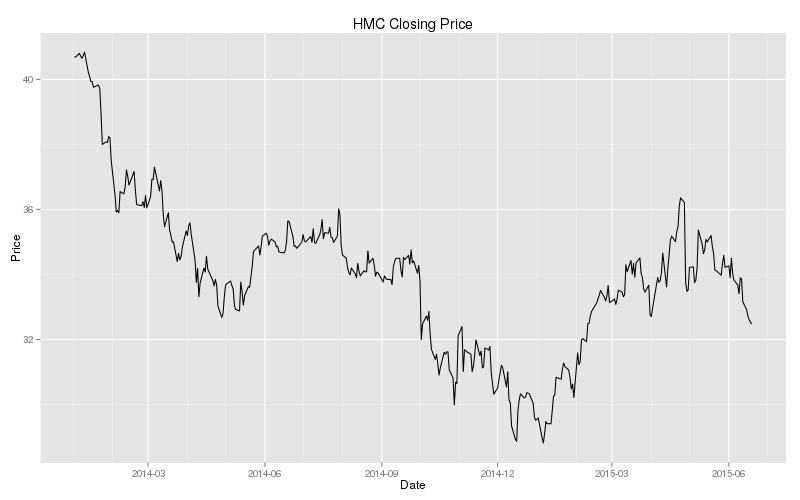

In [8]:
%%R -w 800 -h 500 -u px # Set size of chart.  Instead of px, you can also choose 'in', 'cm', or 'mm'
df = as.data.frame(df)  # ensure dataframe that was passed in from Python will be R's dataframe type
library(ggplot2)
library(scales)
p = ggplot(df, aes(df$Date, df$Adj.Close))
p = p + 
    geom_line() +
    ggtitle("HMC Closing Price") +
    scale_x_datetime(labels=date_format("%Y-%m"), breaks="3 months", minor_breaks="1 month") +
    xlab("Date") +
    ylab("Price")
print(p)

## Let's forecast using R's forecast package

In [12]:
%%R
library(forecast)
HoltWinters(df$Adj.Close)  # We're usign Holt-Winters, but there are several other models to choose from


Error in decompose(ts(x[1L:wind], start = start(x), frequency = f), seasonal) : 
  time series has no or less than 2 periods


#### Error message just means no seasonality was detected.  So we will not use gamma in our model.

## Let's output a summary of our H-W model

In [9]:
%%R
hwm = HoltWinters(df$Adj.Close, gamma=FALSE)
hwf = forecast.HoltWinters(hwm, h=20)  # forecast out to 20 time periods
summary(hwf)


Forecast method: HoltWinters

Model Information:
Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = df$Adj.Close, gamma = FALSE)

Smoothing parameters:
 alpha: 0.9958192
 beta : 0
 gamma: FALSE

Coefficients:
      [,1]
a 32.48021
b  0.00000

Error measures:
                      ME      RMSE       MAE         MPE     MAPE      MASE
Training set -0.02246391 0.4151351 0.3016036 -0.05416424 0.894788 0.9982537
                     ACF1
Training set -0.002765243

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
370       32.48021 31.94825 33.01217 31.66664 33.29378
371       32.48021 31.72947 33.23095 31.33206 33.62837
372       32.48021 31.56139 33.39903 31.07500 33.88542
373       32.48021 31.41962 33.54080 30.85818 34.10224
374       32.48021 31.29468 33.66574 30.66710 34.29332
375       32.48021 31.18171 33.77871 30.49433 34.46609
376       32.48021 31.07781 33.88261 30.33543 34.62499
377       32.48021 30.98110 33.979

#### Above is our point forecasts and their respective 80th- and 95th-percentile confidence intervals

## Now let's plot the actual data and forecast together with confidence intervals

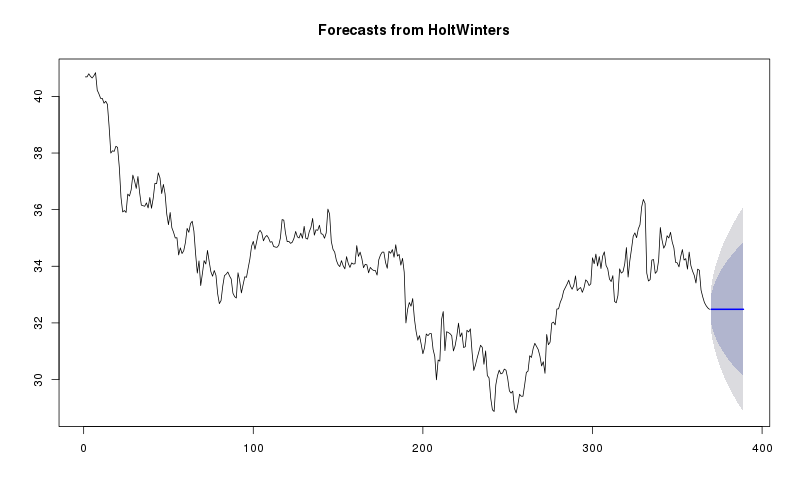

In [13]:
%%R -w 800 -h 500 -u px
plot.forecast(hwf)

The darker grey region represents the 80th percentile, while the lighter grey region represents the 95th percentile.  Using the 95th percentile forecast, Honda's stock can be anywhere from \$28.86 to \$36.10 after 20 months since June 19, 2015.